# create datasets

In [1]:
# !pip3 install numpy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(1)

In [4]:
n_datasets = 200
n_conditions_same = 2
n_conditions_different = 3
n_cells = 300
overlap = 0.1

prefix_rows = "data_"
prefix_cols = "cell_"

# if you want to scale the n_cells based on the n_datasets, uncomment this:
# scaling = 0.5
# n_cells = round((n_datasets) / 2 + (n_datasets) * (scaling - overlap) * (n_conditions_different - 1))
# if n_cells < 50: 
#     n_cells = 50
# n_cells

In [5]:
# divide the datasets in the conditions
size = round(n_datasets / n_conditions_different)
datasets_conditions = [i for i in range(n_conditions_different) for j in range(n_datasets // n_conditions_different + (i < n_datasets % n_conditions_different))]
datasets_conditions2 = [i % n_conditions_same for i in range(n_datasets)]

In [6]:
# calculate the amount of cells per condition and create list with start of cells
n_cells_per_condition = round((n_cells + (n_conditions_different - 1) * overlap * n_cells) / n_conditions_different)
conditions = []

for i in range(n_conditions_different):
    start = round(i * (n_cells_per_condition - overlap * n_cells))
    conditions.append(start)

In [7]:
# empty arrays
ds = np.zeros(n_datasets)
cs = np.zeros((n_datasets, n_cells))

# generate random number of cells per dataset
for i in range(n_datasets):
    ds[i] = round(np.random.random() * 100000)

# get alphas
alphas_list = []
for i in range(n_conditions_different):
    alphas = [2.0] * (conditions[i] - 0) + [10.0] * n_cells_per_condition + [2.0] * (n_cells - n_cells_per_condition - (conditions[i] - 0))
    alphas_list.append(alphas)

# calculate fractions
for i in range(n_datasets):
    condition = datasets_conditions[i]
    alphas = alphas_list[condition]
    fractions = np.random.dirichlet(alphas)
    cs[i] = [round(f) for f in fractions * ds[i]]   

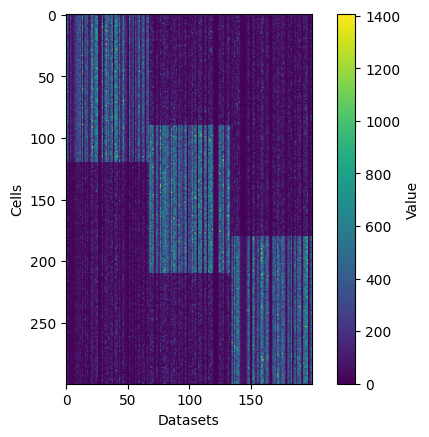

In [8]:
# quick heatmap to check
plt.imshow(cs.transpose())
plt.colorbar(label='Value')

plt.xlabel('Datasets')
plt.ylabel('Cells')

plt.show()

In [9]:
# countsmatrix
countsMatrix = []
for i in range(n_datasets):
    for j in range(n_cells):
        # obs = { "row": f"{prefix_rows}{i}", "col": f"{prefix_cols}{j}", "value": round(cs[i][j]) }
        obs = [f"{prefix_rows}{i}", f"{prefix_cols}{j}", round(cs[i][j])]
        countsMatrix.append(obs)


# rows
different = ["kidney", "liver", "heart", "lung", "brain", "spleen", "colon"]
same = ["male", "female", "other"]

row_names = []
metadata_rows = {}
for i in range(n_datasets):
    row_names.append(f"{prefix_rows}{i}")

    condition_different = datasets_conditions[i]
    condition_same = datasets_conditions2[i]
    obs = {"title": "Example title", "dataset_type": "RNAseq [Salmon]", "anatomy": different[condition_different], "sex": same[condition_same], "age": 65}
    metadata_rows[f"{prefix_rows}{i}"] = obs

# cols
col_names = []
metadata_cols = {}
for j in range(n_cells):
    col_names.append(f"{prefix_cols}{j}")

    obs = {"Cell Ontology Label": "Example label"}
    metadata_cols[f"{prefix_cols}{j}"] = obs

# combine
res = {
    "countsMatrix": countsMatrix,
    "rowNames": row_names,
    "colNames": col_names,
    "metadata": {
        "rows": metadata_rows,
        "cols": metadata_cols,
    }
}

In [10]:
# write to file
def format_dict(res, indent=0):
    formatted_items = []
    indent_str = "  " * indent
    next_indent_str = "  " * (indent + 1)
    for key, value in res.items():
        if isinstance(key, str) and " " in key:
            key = f'"{key}"'  # keep "" if space in key 
        if isinstance(value, dict):
            formatted_value = format_dict(value, indent + 1)
        elif isinstance(value, list):
            formatted_value = format_list(value, indent + 1)
        else:
            formatted_value = repr(value)
        formatted_items.append(f'{next_indent_str}{key}: {formatted_value}')
    return "{\n" + ",\n".join(formatted_items) + f"\n{indent_str}}}"

def format_list(l, indent=0):
    indent_str = "  " * indent
    next_indent_str = "  " * (indent + 1)
    formatted_items = []
    for item in l:
        if isinstance(item, dict):
            formatted_items.append(format_dict(item, indent + 1))
        else:
            formatted_items.append(repr(item))
    return "[\n" + ",\n".join(f"{next_indent_str}{item}" for item in formatted_items) + f"\n{indent_str}]"

formatted_res = format_dict(res)

# this writes out the data to a "file.js"
with open("file.js", "w") as file:
    file.write(formatted_res)